<a href="https://colab.research.google.com/github/Zdestrion/ML_pvt_repo/blob/master/Semi_def_NN_Mini_BooNE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Utilizzo di una semplice Neural Network per la classificazione

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Si importano anzitutto le librerie utili:


In [2]:
#Various basic imports and libraries

import tensorflow as tf
from tensorflow import keras

import numpy as np

import pandas as pd
import time
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
#from mpl_toolkits.axes_grid1 import make_axes_locatable

from scipy import stats 

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

warnings.filterwarnings('ignore')

Si importa il dataset da Drive, utilizzando Pandas per una rappresentazione dei dati più comoda. \\
Si assegna una colonna di feature finale adibita alle labels, basata sulle informazioni che si hanno sui dati (primi 36499 di segnale, restanti di background).

In [3]:
df_old = pd.read_fwf('/content/drive/My Drive/Colab Notebooks/dataset/MiniBooNE_PID.txt')

In [4]:
df_old["signal"]=0
df_old.iloc[0:36499,50]=1
df_old.iloc[36499:,50]=0
df_old

,36499 93565,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,signal
0,2.59413,0.468803,20.6916,0.322648,0.009682,0.374393,0.803479,0.896592,3.59665,0.249282,4.18624,135.885000,0.928671,0.140918,2.58663,1689.070,1.197950,19.35610,0.398340,0.658684,1.561270,0.320885,108.8560,5.16994,0.491493,0.868283,29.6141,1.222990,0.190005,-0.654163,4.97666,0.908007,0.385076,377.412,0.136108,0.310650,2.952640,-4.55567,0.934167,0.049752,101.174,-31.37300,0.442259,5.86453,0.000000,0.090519,0.176909,0.457585,0.071769,0.245996,1
1,3.86388,0.645781,18.1375,0.233529,0.030733,0.361239,1.069740,0.878714,3.59243,0.200793,4.65578,331.718000,0.882784,0.368855,2.24638,1388.260,0.839230,6.69510,0.277778,0.944626,1.664640,0.256501,102.4930,5.33218,0.474294,-0.336652,31.5767,1.317170,0.141945,0.093886,5.05478,1.394390,0.325034,215.837,0.082048,0.297530,0.777241,-4.76871,1.438210,0.068714,186.516,45.95970,-0.478507,6.11126,0.001182,0.091800,-0.465572,0.935523,0.333613,0.230621,1
2,3.38584,1.197140,36.0807,0.200866,0.017341,0.260841,1.108950,0.884405,3.43159,0.177167,4.50807,159.396000,0.412250,0.434002,2.38485,992.098,0.514175,16.00300,0.256262,0.318984,-0.727361,0.312139,69.8362,3.44976,0.497076,-0.314786,59.2516,1.187650,0.192565,-0.511144,5.27196,1.002860,1.690870,417.430,0.068628,0.220612,1.390970,-2.02213,1.843790,0.085132,129.931,-11.56080,-0.297008,8.27204,0.003854,0.141721,-0.210559,1.013450,0.255512,0.180901,1
3,4.28524,0.510155,674.2010,0.281923,0.009174,0.000000,0.998822,0.823390,3.16382,0.171678,4.08041,-1.865600,0.833067,0.181294,2.49837,1289.160,0.630307,12.93740,0.266055,1.313580,0.698101,0.306193,148.0340,4.12461,0.494778,0.331151,17.8265,1.700340,0.147487,0.313964,7.91668,1.584410,0.557134,352.699,0.079246,0.338915,-0.331218,-3.52184,1.244390,0.105550,163.978,-18.45860,0.453886,2.48112,0.000000,0.180938,0.407968,4.341270,0.473081,0.258990,1
4,5.93662,0.832993,59.8796,0.232853,0.025066,0.233556,1.370040,0.787424,3.66546,0.174862,4.59180,183.668000,0.398421,0.353034,2.04136,949.231,0.389585,13.91750,0.281003,0.282402,-0.039672,0.233509,106.8670,2.94245,0.464260,-0.033102,139.4700,1.687930,0.117804,0.021927,7.80990,1.317420,0.677348,317.556,0.041526,0.249403,-0.360560,-3.18766,1.808670,0.105852,229.555,42.96000,-0.975752,2.66109,0.000000,0.170836,-0.814403,4.679490,1.924990,0.253893,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.80718,1.451020,174.6920,0.343481,0.002174,0.000000,0.747401,0.725617,3.18501,0.152208,4.09329,-0.707947,0.813344,0.015294,1.83104,520.017,0.192353,7.59299,0.271739,0.580181,2.706590,0.321739,18.9165,4.77587,0.488641,0.578023,106.1100,1.827670,0.174318,0.523787,7.59281,1.451220,0.616285,453.588,0.015260,0.291661,-0.445277,-3.02319,1.513750,0.055040,179.832,-2.74376,0.317051,2.67617,0.000000,0.141958,0.723207,7.446300,3.219320,0.299487,0
130060,5.00527,1.501860,129.9270,0.273477,0.006098,0.109769,1.325370,0.830334,3.40836,0.130794,4.23870,49.729900,0.527637,0.337350,2.32783,779.822,0.295920,12.35990,0.280488,1.630800,-0.447177,0.302846,64.8961,2.66737,0.443424,-0.060302,149.7250,1.565400,0.138097,0.199993,7.29614,1.130380,1.100050,414.089,0.072055,0.288639,0.780298,-2.74524,1.216240,0.110098,120.794,-24.72180,0.312652,4.16524,0.000000,0.232273,0.141153,1.898750,1.778180,0.258058,0
130061,3.10842,2.178140,56.3651,0.211850,0.000000,0.

Per fare in modo di prendere uno splitting il più casuale possibile, si applica uno shuffle alle righe.

In [5]:
#Shuffling
df = df_old.sample(frac=1).reset_index(drop=True)

In [6]:
df

,36499 93565,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,signal
0,3.23910,0.650082,73.07690,0.284021,0.013966,0.305641,1.235560,0.881763,3.42876,0.222317,4.37056,225.65600,0.768483,0.221226,2.60594,1506.240,0.896676,3.07103,0.298883,0.900611,1.265600,0.337989,87.6330,5.38347,0.462724,0.348580,19.72780,1.21445,0.155739,-0.228509,5.52958,1.119360,0.655927,287.338,0.131388,0.368074,1.561840,-3.91558,1.371340,0.062729,148.1450,-9.608630,-0.197143,3.57699,0.000000,0.104665,0.110171,0.951492,0.249577,0.180645,1
1,6.99265,1.555350,115.64500,0.341919,0.000000,0.056076,0.402025,0.796726,3.68052,0.177033,4.17113,216.11000,0.980744,0.024239,1.98841,739.689,0.223714,18.37200,0.358921,0.503178,0.765871,0.417012,41.1031,4.39821,0.333553,2.049460,118.60200,1.74733,0.285730,-0.118235,10.50970,0.579043,0.943634,404.958,0.035122,0.194999,-1.024480,-3.05209,1.387090,0.073481,122.8950,-21.790900,0.335006,4.36008,0.000000,0.135657,1.368810,4.804400,7.928000,0.243108,0
2,4.70259,2.745000,8.31279,0.210972,0.020710,0.274197,1.713310,0.729363,4.05988,0.147135,4.96600,151.80800,0.849122,0.513392,1.80591,503.849,0.203789,7.15477,0.340237,1.818940,-1.423030,0.248521,69.3878,3.18276,0.481383,-2.841960,50.45340,1.44074,0.105899,-1.556240,6.20401,1.396850,1.931440,455.022,0.057345,0.308461,0.873459,-1.68042,0.834884,0.125140,86.2126,0.272453,5.084580,12.26440,0.020710,0.133798,-0.103665,1.438150,1.309860,0.264129,0
3,5.51759,1.647710,117.42000,0.336041,0.000000,0.000000,0.615533,0.766352,3.35489,0.092331,3.84569,84.65970,-0.537825,0.020286,2.03671,537.691,0.203159,34.38200,0.291572,1.037870,1.445170,0.343964,36.4269,2.22261,0.418331,0.562172,144.51700,1.74540,0.165381,-0.050244,8.97804,0.998336,1.956200,413.526,0.026629,0.202256,-0.301004,-1.82419,1.415250,0.110642,143.9200,6.873400,0.335507,2.38315,0.000000,0.275264,0.749856,4.686740,3.150770,0.295350,0
4,5.24549,1.410260,156.95900,0.282424,0.018083,0.142558,0.572190,0.794416,3.64391,0.106289,4.68666,335.47100,0.379778,0.700121,1.88006,791.503,0.337016,12.90730,0.222423,0.802852,-1.180820,0.244123,61.2059,3.95659,0.419558,-2.173700,151.31200,1.58498,0.155316,-0.384367,7.20422,0.995698,1.117110,237.176,0.090582,0.334950,0.175203,-3.03287,1.231880,0.081061,175.4530,-37.833900,0.108462,9.88185,0.014466,0.182266,-0.634365,2.571890,-0.439253,0.199084,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.17954,0.466373,69.36150,0.232875,0.034339,0.243757,1.174970,0.894543,3.29154,0.163828,4.77717,78.53280,0.664357,0.541418,3.25194,1840.600,0.857531,11.19540,0.191467,0.818368,-1.538680,0.286160,255.0080,2.45488,0.496792,-0.138093,256.84300,1.60983,0.120316,0.070172,8.59634,1.149100,0.712370,367.217,0.061595,0.249713,-0.091001,-3.59520,1.562800,0.123587,199.1850,26.676400,-0.353167,2.52408,0.007284,0.250032,-0.804801,2.616550,0.483639,0.235735,1
130060,4.01851,1.440660,6.52664,0.225277,0.005405,0.486777,1.414090,0.825148,3.41180,0.219344,4.49411,289.96800,0.462245,0.192443,1.79699,691.841,0.408175,7.88433,0.293694,1.502760,0.849160,0.326126,42.9025,6.82745,0.472677,0.499135,3.95525,1.64582,0.106692,0.129395,6.22172,1.676470,0.210944,260.014,0.089568,0.423794,0.062384,-4.62445,1.087180,0.054455,141.7330,0.607867,0.864713,3.99653,0.000000,0.087762,0.402050,1.632700,0.914416,0.266890,1
130061,4.43895,1.348580,546.93200,0.309476,0.

Si mantiene un dataframe comprensivo di outliers e se ne modifica un secondo escludendo questi ultimi secondo un criterio "permissivo", eliminando semplicemente i dati oltre le 3 $\sigma$.

In [7]:
df_outliers = df

In [8]:
z = np.abs(stats.zscore(df))
df = df[(z < 3).all(axis=1)]
df

,36499 93565,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28,Unnamed: 29,Unnamed: 30,Unnamed: 31,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41,Unnamed: 42,Unnamed: 43,Unnamed: 44,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,signal
0,3.23910,0.650082,73.07690,0.284021,0.013966,0.305641,1.235560,0.881763,3.42876,0.222317,4.37056,225.65600,0.768483,0.221226,2.60594,1506.240,0.896676,3.07103,0.298883,0.900611,1.265600,0.337989,87.6330,5.38347,0.462724,0.348580,19.72780,1.21445,0.155739,-0.228509,5.52958,1.119360,0.655927,287.338,0.131388,0.368074,1.561840,-3.91558,1.371340,0.062729,148.1450,-9.608630,-0.197143,3.57699,0.000000,0.104665,0.110171,0.951492,0.249577,0.180645,1
1,6.99265,1.555350,115.64500,0.341919,0.000000,0.056076,0.402025,0.796726,3.68052,0.177033,4.17113,216.11000,0.980744,0.024239,1.98841,739.689,0.223714,18.37200,0.358921,0.503178,0.765871,0.417012,41.1031,4.39821,0.333553,2.049460,118.60200,1.74733,0.285730,-0.118235,10.50970,0.579043,0.943634,404.958,0.035122,0.194999,-1.024480,-3.05209,1.387090,0.073481,122.8950,-21.790900,0.335006,4.36008,0.000000,0.135657,1.368810,4.804400,7.928000,0.243108,0
2,4.70259,2.745000,8.31279,0.210972,0.020710,0.274197,1.713310,0.729363,4.05988,0.147135,4.96600,151.80800,0.849122,0.513392,1.80591,503.849,0.203789,7.15477,0.340237,1.818940,-1.423030,0.248521,69.3878,3.18276,0.481383,-2.841960,50.45340,1.44074,0.105899,-1.556240,6.20401,1.396850,1.931440,455.022,0.057345,0.308461,0.873459,-1.68042,0.834884,0.125140,86.2126,0.272453,5.084580,12.26440,0.020710,0.133798,-0.103665,1.438150,1.309860,0.264129,0
3,5.51759,1.647710,117.42000,0.336041,0.000000,0.000000,0.615533,0.766352,3.35489,0.092331,3.84569,84.65970,-0.537825,0.020286,2.03671,537.691,0.203159,34.38200,0.291572,1.037870,1.445170,0.343964,36.4269,2.22261,0.418331,0.562172,144.51700,1.74540,0.165381,-0.050244,8.97804,0.998336,1.956200,413.526,0.026629,0.202256,-0.301004,-1.82419,1.415250,0.110642,143.9200,6.873400,0.335507,2.38315,0.000000,0.275264,0.749856,4.686740,3.150770,0.295350,0
4,5.24549,1.410260,156.95900,0.282424,0.018083,0.142558,0.572190,0.794416,3.64391,0.106289,4.68666,335.47100,0.379778,0.700121,1.88006,791.503,0.337016,12.90730,0.222423,0.802852,-1.180820,0.244123,61.2059,3.95659,0.419558,-2.173700,151.31200,1.58498,0.155316,-0.384367,7.20422,0.995698,1.117110,237.176,0.090582,0.334950,0.175203,-3.03287,1.231880,0.081061,175.4530,-37.833900,0.108462,9.88185,0.014466,0.182266,-0.634365,2.571890,-0.439253,0.199084,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
130059,4.17954,0.466373,69.36150,0.232875,0.034339,0.243757,1.174970,0.894543,3.29154,0.163828,4.77717,78.53280,0.664357,0.541418,3.25194,1840.600,0.857531,11.19540,0.191467,0.818368,-1.538680,0.286160,255.0080,2.45488,0.496792,-0.138093,256.84300,1.60983,0.120316,0.070172,8.59634,1.149100,0.712370,367.217,0.061595,0.249713,-0.091001,-3.59520,1.562800,0.123587,199.1850,26.676400,-0.353167,2.52408,0.007284,0.250032,-0.804801,2.616550,0.483639,0.235735,1
130060,4.01851,1.440660,6.52664,0.225277,0.005405,0.486777,1.414090,0.825148,3.41180,0.219344,4.49411,289.96800,0.462245,0.192443,1.79699,691.841,0.408175,7.88433,0.293694,1.502760,0.849160,0.326126,42.9025,6.82745,0.472677,0.499135,3.95525,1.64582,0.106692,0.129395,6.22172,1.676470,0.210944,260.014,0.089568,0.423794,0.062384,-4.62445,1.087180,0.054455,141.7330,0.607867,0.864713,3.99653,0.000000,0.087762,0.402050,1.632700,0.914416,0.266890,1
130061,4.43895,1.348580,546.93200,0.309476,0.

Si creano dunque i vettori di dati e label per entrambi i dataframe, normalizzando i dati con $\textit{MinMaxScaler}$.

In [9]:
labels = df["signal"].values

data = df.drop(labels='signal', axis=1)
scaler = MinMaxScaler()
data = scaler.fit_transform(data)

print(labels.shape)
print(data.shape)

(123480,)
(123480, 50)


In [10]:
labels_out = df_outliers["signal"].values

data_out = df_outliers.drop(labels='signal', axis=1)
data_out = scaler.fit_transform(data_out)

print(labels_out.shape)
print(data_out.shape)

(130064,)
(130064, 50)


In [11]:
data = data.astype('float32')
labels = labels.astype('float32')
data_out = data_out.astype('float32')
labels_out = labels_out.astype('float32')

In [12]:
#Splitting
train_to_test_ratio=0.8

X_train,X_test,Y_train_nc,Y_test_nc=train_test_split(data,labels,train_size=train_to_test_ratio)
#Y_train = keras.utils.to_categorical(Y_train_nc)
#Y_test = keras.utils.to_categorical(Y_test_nc)
print(X_train.shape)
print(X_test.shape)
print(Y_train_nc.shape)
print(Y_test_nc.shape)


(98784, 50)
(24696, 50)
(98784,)
(24696,)


Si definisce dunque una funzione che crei il modello di Rete Neurale desiderato. Si decide di optare per un modello semplice, che consta di tre blocchi densi, ciascuno costituito da:
* layer denso (256 units);
* layer di Batch Normalization;
* layer di attivazione ReLU;
* layer di Dropout (rate rispettivamente 0.5, 0.2, 0.2).

Dopo i tre blocchi densi vi è un layer denso ad una singola unità, con attivazione sigmoide, utile al fine della classificazione che si vuole operare (background/signal, 0/1). \\
Il numero di units dei layer densi e il rate dei layer di dropout sono stati tunati in precedenza mediante l'utilizzo di HyperBand, messo a disposizione da Keras. L'idea alla base di un rate di dropout maggiore nel primo blocco è funzionale alla riduzione dell'overfitting. A questo fine e per uno smoothing della loss function e della accuracy vengono utilizzati i layer di Batch Normalization e (come si vedrà in seguito) il decadimento esponenziale del learning rate. 

Model: "MiniBooNE_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
Dense_1 (Dense)              (None, 256)               13056     
_________________________________________________________________
batch_normalization (BatchNo (None, 256)               1024      
_________________________________________________________________
ReLU_dense_1 (ReLU)          (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
Dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)             

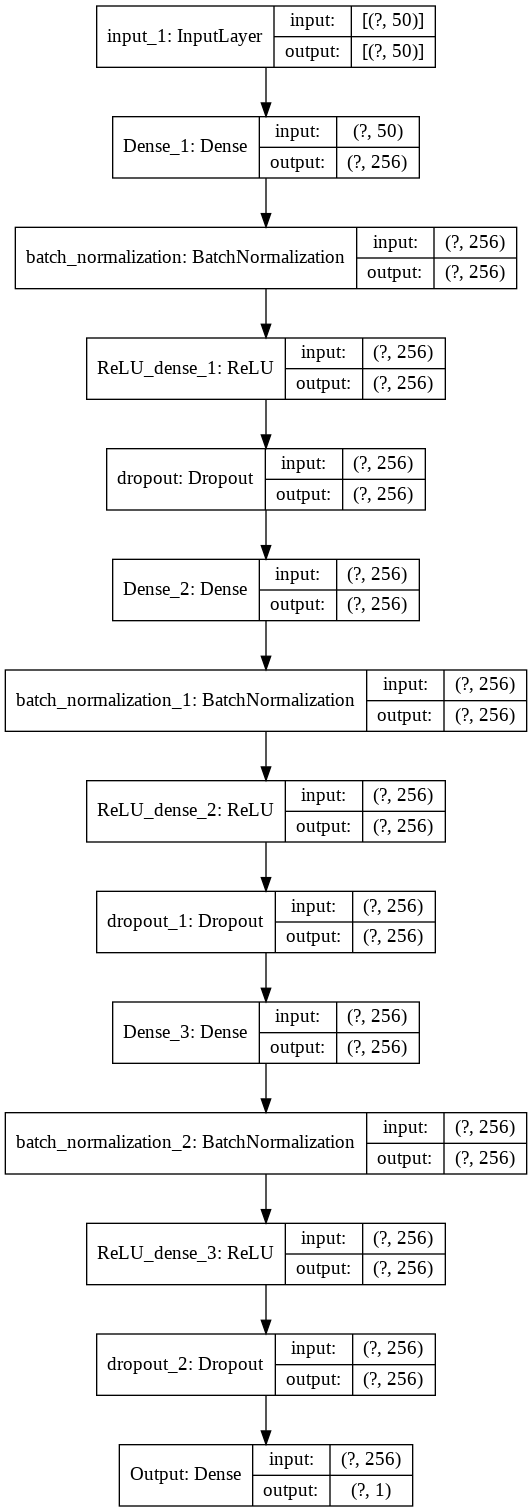

In [13]:
#Model definition (functional)
def create_model():
  inputs = keras.Input(shape=(50))
  x = inputs

  x = keras.layers.Dense(256, name='Dense_1')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU(name='ReLU_dense_1')(x)
  x = keras.layers.Dropout(rate=0.5)(x)

  x = keras.layers.Dense(256, name='Dense_2')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU(name='ReLU_dense_2')(x)
  x = keras.layers.Dropout(rate=0.2)(x)

  x = keras.layers.Dense(256, name='Dense_3')(x)
  x = keras.layers.BatchNormalization()(x)
  x = keras.layers.ReLU(name='ReLU_dense_3')(x)
  x = keras.layers.Dropout(rate=0.2)(x)
  
  outputs = keras.layers.Dense(1, activation='sigmoid', name='Output')(x)

  model = keras.Model(inputs=inputs, outputs=outputs, name='MiniBooNE_CNN')
  return model

model = create_model()  
model.summary()

keras.utils.plot_model(model, show_shapes=True)

Per questo problema in particolare si è riteso opportuno utilizzare la $\textit{binary crossentropy}$ come loss function e utilizzare come metriche del modello l'accuracy e la AUC (Area Under Curve). \\
Si prova il training con un learning rate con decadimento esponenziale, ottimizzato tramite Adam:

In [79]:
LR_ST=(1e-2)*2
OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
model= create_model()
EAGERLY = False
auc = keras.metrics.AUC()

model.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=['accuracy', auc],
              run_eagerly=EAGERLY)

Si opta dunque per un decadimento esponenziale $e^{0.035*(10-epoch)}$, in modo che il learning rate non decada troppo bruscamente e la rete continui ad imparare adeguatamente prima di arrivare a saturazione. \\
Il rate di decadimento e l'epoca dalla quale iniziare a far decadere il learning rate sono stati scelti in modo fossero adeguati al numero di epoche totali scelto (100) e all'architettura della rete. \\
Con un numero di epoche maggiori (es: 1000) sarebbe stato possibile scegliere dropout maggiore e learning rate minore, ad esempio. ??????????????????????????????????????????????????????????????????????????????????????????????????????????

In [80]:
def lr_decay(epoch):
  if epoch < 10:
    return LR_ST
  else:
    return LR_ST * tf.math.exp(0.035 * (10 - epoch))

lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)

model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch_constant',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

start_time = time.time()

history = model.fit(X_train, Y_train_nc, epochs=100, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=2,
                    callbacks=callbacks)

print("\n\nTime to train the neural network:", time.time()-start_time)
                    

Epoch 1/100
618/618 - 4s - loss: 0.2050 - accuracy: 0.9167 - auc_5: 0.9654 - val_loss: 0.2335 - val_accuracy: 0.8874 - val_auc_5: 0.9725 - lr: 0.0200
Epoch 2/100
618/618 - 4s - loss: 0.1783 - accuracy: 0.9286 - auc_5: 0.9737 - val_loss: 0.1964 - val_accuracy: 0.9084 - val_auc_5: 0.9786 - lr: 0.0200
Epoch 3/100
618/618 - 4s - loss: 0.1726 - accuracy: 0.9310 - auc_5: 0.9753 - val_loss: 0.1925 - val_accuracy: 0.9130 - val_auc_5: 0.9781 - lr: 0.0200
Epoch 4/100
618/618 - 4s - loss: 0.1674 - accuracy: 0.9332 - auc_5: 0.9767 - val_loss: 0.1596 - val_accuracy: 0.9362 - val_auc_5: 0.9804 - lr: 0.0200
Epoch 5/100
618/618 - 4s - loss: 0.1648 - accuracy: 0.9338 - auc_5: 0.9774 - val_loss: 0.1622 - val_accuracy: 0.9363 - val_auc_5: 0.9799 - lr: 0.0200
Epoch 6/100
618/618 - 4s - loss: 0.1630 - accuracy: 0.9347 - auc_5: 0.9780 - val_loss: 0.1961 - val_accuracy: 0.9156 - val_auc_5: 0.9773 - lr: 0.0200
Epoch 7/100
618/618 - 4s - loss: 0.1597 - accuracy: 0.9357 - auc_5: 0.9787 - val_loss: 0.1600 - val_

In [81]:
model.load_weights('best_epoch_constant')

In [82]:
test_loss, test_acc, test_auc = model.evaluate(X_test, Y_test_nc, verbose=1)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)
print('\nTest auc:', test_auc)


772/772 [==============================] - 2s 3ms/step - loss: 0.1249 - accuracy: 0.9515 - auc_5: 0.9867

Test loss: 0.12486758083105087

Test accuracy: 0.9514901041984558

Test auc: 0.9867414236068726


La loss e l'accuracy raggiungono valori soddisfacenti, soprattutto se comparati a quelli ottenuti tramite i Boosted Decision Trees. \\
In media, si ottiene un'accuracy che oscilla, a seconda della run, tra il $95\%$ e il $95.3\%$. Ulteriore riprova della bontà della rete e la AUC, stabilmente a 0.987. \\
Il tempo computazionale per ottenere tali valori risulta inoltre decisamente minore rispetto al tempo impiegato dagli algoritmi di Boosting. \\
Di seguito si plottano la loss e l'accuracy per mostrarne l'andamento più dettagliatamente.

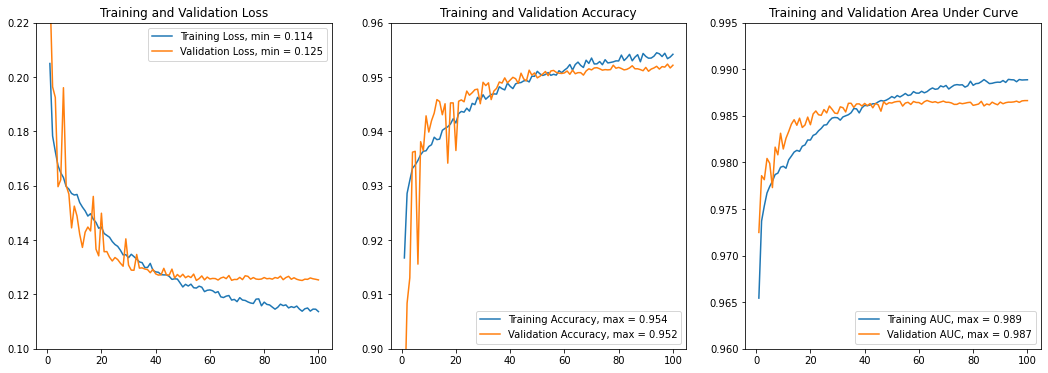

In [83]:
#plot della loss e della accuracy durante il training
plt.close()
plt.figure(figsize=(18, 6))
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
max_acc = np.amax(acc)
max_val_acc = np.amax(val_acc)

loss=history.history['loss']
val_loss=history.history['val_loss']
min_loss = np.amin(loss)
min_val_loss = np.amin(val_loss)

auc_in = history.history['auc']
val_auc = history.history['val_auc']
max_auc = np.amax(auc_in)
max_val_auc = np.amax(val_auc)

epochs_range = range(1, len(loss) + 1)

plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss, label='Training Loss, min = %.3f'%min_loss)
plt.plot(epochs_range, val_loss, label='Validation Loss, min = %.3f'%min_val_loss)
plt.legend(loc='upper right')
plt.ylim(0.1,0.22)
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, acc, label='Training Accuracy, max = %.3f'%max_acc)
plt.plot(epochs_range, val_acc, label='Validation Accuracy, max = %.3f'%max_val_acc)
plt.legend(loc='lower right')
plt.ylim(0.90,0.96)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, auc_in, label='Training AUC, max = %.3f'%max_auc)
plt.plot(epochs_range, val_auc, label='Validation AUC, max = %.3f'%max_val_auc)
plt.legend(loc='lower right')
plt.ylim(0.96,0.995)
plt.title('Training and Validation Area Under Curve')
plt.show()

E' particolarmente interessante notare come, nonostante inizialmente le curve di validation risultino poco smooth a causa probabilmente del learning rate elevato, grazie all'espressione utilizzata per il decadimento giungono al loro valore asintotico attorno alle 60 epoche. Dalla funzione di loss del training si nota come un aumento di epoche avrebbe probabilmente condotto inesorabilmente ad un overfitting, più che ad un vero e proprio miglioramento della capacità di classificazione.

Si prova ora ad includere gli outliers per un confronto di prestazione.

In [24]:
#Splitting
train_to_test_ratio=0.8

X_train_out,X_test_out,Y_train_nc_out,Y_test_nc_out=train_test_split(data_out,labels_out,train_size=train_to_test_ratio)
#Y_train_out = keras.utils.to_categorical(Y_train_nc_out)
#Y_test_out = keras.utils.to_categorical(Y_test_nc_out)
print(X_train_out.shape)
print(X_test_out.shape)
print(Y_train_nc_out.shape)
print(Y_test_nc_out.shape)

(104051, 50)
(26013, 50)
(104051,)
(26013,)


In [48]:
LR_ST=(1e-2)*2

OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=LR_ST)
model = create_model()
EAGERLY = False
auc = keras.metrics.AUC()

model.compile(optimizer=OPTIMIZER,
              loss='binary_crossentropy',
              metrics=['accuracy', auc],
              run_eagerly=EAGERLY)

In [49]:
lr_scheduler = keras.callbacks.LearningRateScheduler(lr_decay)
model_checkpoint = keras.callbacks.ModelCheckpoint(
        filepath = 'best_epoch_outliers',
        verbose = 0,
        save_weights_only = True, 
        save_freq = 'epoch',
        save_best_only = True,
        mode ='min')

callbacks = [ lr_scheduler, model_checkpoint ]

start_time = time.time()

history_out = model.fit(X_train_out, Y_train_nc_out, epochs=100, batch_size=128,
                    validation_split=0.2, shuffle=True, verbose=2,
                    callbacks=callbacks)

print("\n\nTime to train the neural network:", time.time()-start_time)                    

Epoch 1/100
651/651 - 4s - loss: 0.3064 - accuracy: 0.8685 - auc_3: 0.9276 - val_loss: 0.5902 - val_accuracy: 0.8460 - val_auc_3: 0.9104 - lr: 0.0200
Epoch 2/100
651/651 - 4s - loss: 0.2793 - accuracy: 0.8804 - auc_3: 0.9399 - val_loss: 0.5931 - val_accuracy: 0.7973 - val_auc_3: 0.8880 - lr: 0.0200
Epoch 3/100
651/651 - 4s - loss: 0.2690 - accuracy: 0.8852 - auc_3: 0.9444 - val_loss: 0.6493 - val_accuracy: 0.7570 - val_auc_3: 0.8985 - lr: 0.0200
Epoch 4/100
651/651 - 4s - loss: 0.2667 - accuracy: 0.8865 - auc_3: 0.9452 - val_loss: 0.6214 - val_accuracy: 0.7209 - val_auc_3: 0.8714 - lr: 0.0200
Epoch 5/100
651/651 - 4s - loss: 0.2588 - accuracy: 0.8903 - auc_3: 0.9485 - val_loss: 0.4863 - val_accuracy: 0.7497 - val_auc_3: 0.9188 - lr: 0.0200
Epoch 6/100
651/651 - 4s - loss: 0.2558 - accuracy: 0.8932 - auc_3: 0.9497 - val_loss: 0.6593 - val_accuracy: 0.5406 - val_auc_3: 0.8842 - lr: 0.0200
Epoch 7/100
651/651 - 4s - loss: 0.2488 - accuracy: 0.8957 - auc_3: 0.9526 - val_loss: 0.5121 - val_

In [57]:
model.load_weights('best_epoch_outliers')

In [58]:
test_loss, test_acc, test_auc = model.evaluate(X_test_out, Y_test_nc_out, verbose=1)
print('\nTest loss:', test_loss)
print('\nTest accuracy:', test_acc)
print('\nTest auc:', test_auc)


813/813 [==============================] - 2s 3ms/step - loss: 0.1943 - accuracy: 0.9217 - auc_3: 0.9738

Test loss: 0.19433990120887756

Test accuracy: 0.9216545820236206

Test auc: 0.9737746715545654


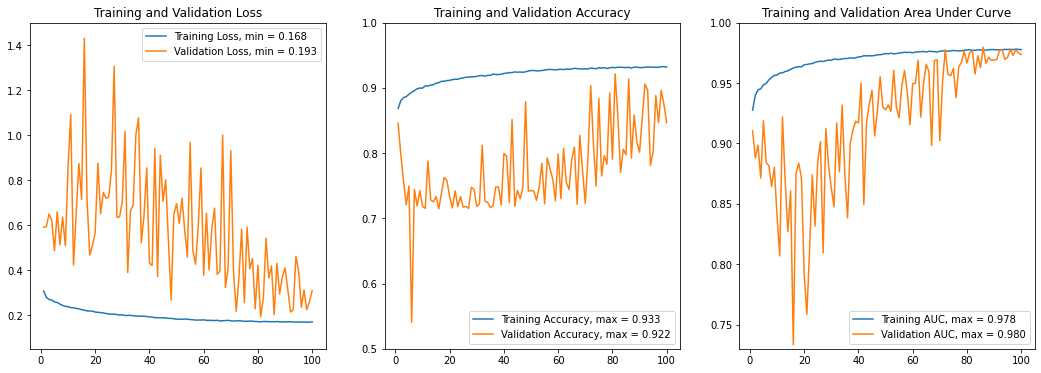

In [63]:
#plot della loss e della accuracy durante il training
plt.close()
plt.figure(figsize=(18, 6))
acc_out = history_out.history['accuracy']
val_acc_out = history_out.history['val_accuracy']
max_acc_out = np.amax(acc_out)
max_val_acc_out = np.amax(val_acc_out)

loss_out=history_out.history['loss']
val_loss_out=history_out.history['val_loss']
min_loss_out = np.amin(loss_out)
min_val_loss_out = np.amin(val_loss_out)

auc_out = history_out.history['auc_3']
val_auc_out = history_out.history['val_auc_3']
max_auc_out = np.amax(auc_out)
max_val_auc_out = np.amax(val_auc_out)

epochs_range = range(1, len(loss) + 1)

plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss_out, label='Training Loss, min = %.3f'%min_loss_out)
plt.plot(epochs_range, val_loss_out, label='Validation Loss, min = %.3f'%min_val_loss_out)
plt.legend(loc='upper right')
plt.ylim(0.05,1.5)
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, acc_out, label='Training Accuracy, max = %.3f'%max_acc_out)
plt.plot(epochs_range, val_acc_out, label='Validation Accuracy, max = %.3f'%max_val_acc_out)
plt.legend(loc='lower right')
plt.ylim(0.5,1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, auc_out, label='Training AUC, max = %.3f'%max_auc_out)
plt.plot(epochs_range, val_auc_out, label='Validation AUC, max = %.3f'%max_val_auc_out)
plt.legend(loc='lower right')
plt.ylim(0.73,1.)
plt.title('Training and Validation Area Under Curve')
plt.show()

Si nota come l'addestramento di una rete con dati comprensivi di outliers riduca sensibilmente le prestazioni. \\
Per un'ulteriore chiarezza si mettono a confronto sul medesimo grafico gli andamenti delle tre curve con e senza outliers:

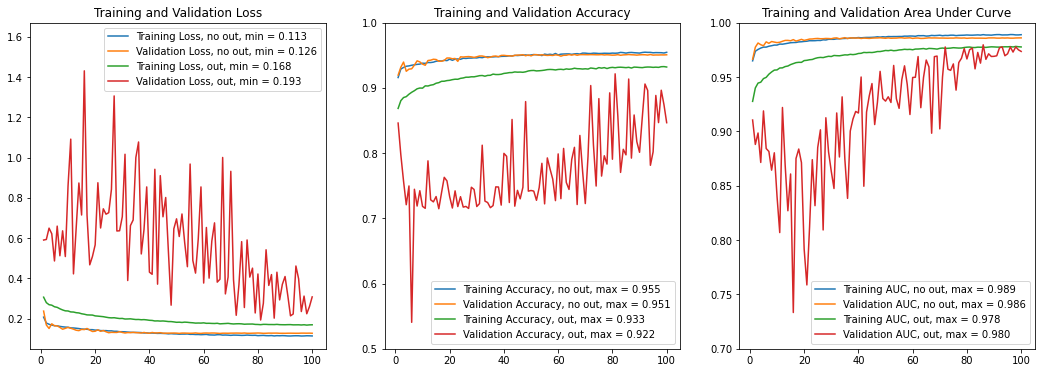

In [71]:
#plot della loss e della accuracy durante il training
plt.close()
plt.figure(figsize=(18, 6))
epochs_range = range(1, len(loss) + 1)

plt.subplot(1, 3, 1)
plt.plot(epochs_range, loss, label='Training Loss, no out, min = %.3f'%min_loss)
plt.plot(epochs_range, val_loss, label='Validation Loss, no out, min = %.3f'%min_val_loss)
plt.plot(epochs_range, loss_out, label='Training Loss, out, min = %.3f'%min_loss_out)
plt.plot(epochs_range, val_loss_out, label='Validation Loss, out, min = %.3f'%min_val_loss_out)
plt.legend(loc='upper right')
plt.ylim(0.05,1.67)
plt.title('Training and Validation Loss')

plt.subplot(1, 3, 2)
plt.plot(epochs_range, acc, label='Training Accuracy, no out, max = %.3f'%max_acc)
plt.plot(epochs_range, val_acc, label='Validation Accuracy, no out, max = %.3f'%max_val_acc)
plt.plot(epochs_range, acc_out, label='Training Accuracy, out, max = %.3f'%max_acc_out)
plt.plot(epochs_range, val_acc_out, label='Validation Accuracy, out, max = %.3f'%max_val_acc_out)
plt.legend(loc='lower right')
plt.ylim(0.5,1)
plt.title('Training and Validation Accuracy')

plt.subplot(1, 3, 3)
plt.plot(epochs_range, auc_in, label='Training AUC, no out, max = %.3f'%max_auc)
plt.plot(epochs_range, val_auc, label='Validation AUC, no out, max = %.3f'%max_val_auc)
plt.plot(epochs_range, auc_out, label='Training AUC, out, max = %.3f'%max_auc_out)
plt.plot(epochs_range, val_auc_out, label='Validation AUC, out, max = %.3f'%max_val_auc_out)
plt.legend(loc='lower right')
plt.ylim(0.7,1.)
plt.title('Training and Validation Area Under Curve')
plt.show()

Si evince facilmente come la funzione di validation comprensiva di outliers sia altamente instabile e come i migliori risultati si ottengano con il dataset privato degli outliers.